In [1]:
import os
import glob
import iris
import pandas as pd
import numpy as np
import logging
import esmvalcore.preprocessor
import xarray as xr
import xesmf as xe
from tqdm import tqdm
from xmip.preprocessing import rename_cmip6
import matplotlib.pyplot as plt
import dask
from nc_processing import calc_spatial_mean
from tqdm import tqdm
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

FileNotFoundError: [Errno 2] No such file or directory: b'/home/users/a_duffey/Transient_vs_eqlbrm_baselines/int_outs/qe_map_means/UKESM1-0-LL.nc'

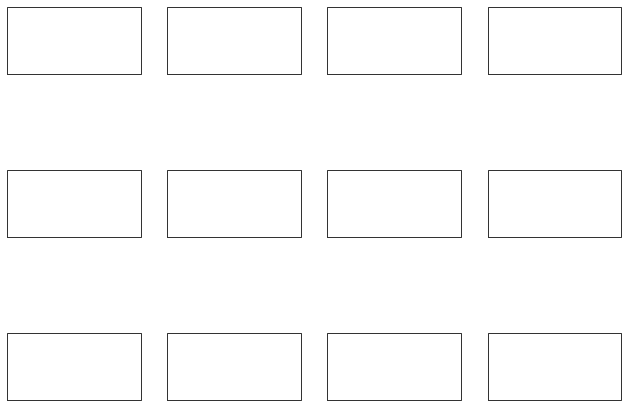

In [3]:
var = 'tas'



folder_QE = 'int_outs/qe_map_means/'
folder_Tr = 'int_outs/tr_map_means/'
folder_Std = 'int_outs/qe_map_boot_stds/'


mods = ['CanESM5', 'GISS-E2-1-G', 'HadGEM3-GC31-LL']


# Define the contour levels to use in plt.contourf
clevs=np.arange(-2.2,2.5,0.4)

nrows=3
ncols=4
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for i,model in enumerate(mods):

        
        QE = xr.open_dataset(folder_QE+'/'+model+'.nc')
        Tr = xr.open_dataset(folder_Tr+'/'+model+'.nc')
        ds = QE - Tr
        data = ds.tas.values
        abs_data = np.absolute(data)
        STD = xr.open_dataset(folder_Std+'/'+model+'.nc')
        sig_mask = xr.where(abs_data > 2*STD.tas.values, 1, 0)
    
        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=ds['x'])
        sig_mask,lons=add_cyclic_point(sig_mask,coord=ds['x'])
    
        # Contour plot
        cs=axs[i].contourf(lons,ds['y'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='RdBu_r',extend='both')

        ##adding hatches:
        cs_hatch = axs[i].contourf(lons,ds['y'],sig_mask,
                                   levels=[0, 0.5, 1.2], colors='none',
                                   hatches=[None,'.', '.'],
                                   extend='neither')

        # Title each subplot with the name of the model
        axs[i].set_title(model)

        # Draw the coastines for each subplot
        axs[i].coastlines()

# Delete the unwanted axes
for i in [5]:
    fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.55, 0.2, 0.4, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', label='tas anom.')

# Add a big title at the top
plt.suptitle('QE - transient (in 20-year window at GMST of QE)')
plt.tight_layout()
plt.savefig('Figures/main.jpg', dpi=450)